# 75.06/95.58 Organización de Datos
# Finger 2: Análisis Exploratorio con Apache Spark: Trocafone.

Utilizando las herramientas que provee Apache Spark, se quiere realizar un análisis exploratorio del Set de datos del Trabajo Práctico de la materia.

Los datos del TP están disponibles desde el siguiente link:

https://drive.google.com/file/d/1gUddcLLujjFfwZslypUv1LESTM6KiwJn/view?usp=sharing

Considerando la siguiente información del set de datos

 - Eventos (events.csv)

Se plantean los siguientes puntos a realizar:

1. Encontrar cuál es el tipo de evento predominante.
2. Encontrar el Top 5 de dispositivos más visitados dentro de la categoría Smartphones.


En http://spark.apache.org/docs/latest/rdd-programming-guide.html puede encontrar la documentación de Spark para apoyar lo dado en clase.

Recomendamos utilizar para la resolución un Notebook de Jupyter Notebook que permita organizar claramente el output y comentar los hallazgos, de tal forma que puedan compartirse por ejemplo en Github.
Los ejercicios deben resolverse utilizando Apache Spark usando e RDDs.
A partir de Spark 2 se pueden leer CSV directamente con los readers integrados en Spark.
Para esto se debe obtener el sqlContext y luego hacer:

dataframe = sqlContext.read.csv('datos.csv')

Con eso se obtiene el dataframe de los datos, que es una abstracción por arriba de los RDD. Se puede obtener el rdd a partir del dataframe haciendo simplemente dataframe.rdd.
Documentación en http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html

Atención: Es importante considerar en la resolución que no es posible traer toda la información al driver de spark desde el cluster. Es necesario poder reducir la información hasta un cierto punto que pueda traerse a la memoria del mismo, por lo que operaciones de sumarización, etc deben realizarse en el cluster.



In [1]:
# Iniciamos pyspark
import findspark
findspark.init()
import pyspark

# Esto es para poder mostrar el texto de resultado resaltado !!
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

    


In [2]:
# Creamos el contexto
sctx = pyspark.SparkContext(appName='Finger 2')
sqlctx = pyspark.sql.SQLContext(sctx)

# Cargamos el rdd
evntrdd = sqlctx.read.csv('..\\..\\Data\\tp1\\events.csv', header=True, mode="DROPMALFORMED").rdd

# Verificamos la cantidad de registros
evntrdd.count()

1011284

## 1. Encontrar cuál es el tipo de evento predominante.


Podriamos intentar hacer lo siguiente
```python
evntrdd.map(lambda a: (a['event'],1)).reduceByKey(lambda a,b: a+b).sortBy(lambda x: x[1], False).first()
```
Esta forma es peligrosa porque sortBy hace shuffle y __no debe__ usarse cuando se busca "el mas" o "el menos" de algo. 

NOTA: Es este caso no sería neceario porque la cantidad distinta de eventos posible es muy pequeña.

<br>
> Siempre se debe tratar de evitar las operaciones que hacen Shuffle hasta tener menos datos
<br>

<br>
<br>
La siguiente es la forma correcta de hacerlo
<br>


In [3]:
eventoPredominante = evntrdd.map(lambda a: (a['event'],1)).reduceByKey(lambda a,b: a+b).reduce(lambda x,y: x if x[1] > y[1] else y)

# Imprimo el resultado
printmd('> __El evento predominante es el "{0}" y contiene {1} eventos__,'.format(eventoPredominante[0],eventoPredominante[1]))


> __El evento predominante es el "viewed product" y contiene 528931 eventos__,

## 2. Encontrar el Top 5 de dispositivos más visitados dentro de la categoría Smartphones.

Dada la ambiguedad del enunciado, porque __no existe en el dataset un feature que significa "categoria"__, analizamos los datos tomando en cuenta primero device_type == 'Smartphone' que es lo más parecido a una categoría ya que esa columna identifica el tipo de dispositivo desde donde se generó el evento

In [4]:
#Filtramos por device_type == 'Smartphone'
print(evntrdd.filter(lambda x : x.device_type == 'Smartphone').count())
print(evntrdd.filter(lambda x : x.device_type == 'Smartphone').filter(lambda x : x.model != None).count())
print(evntrdd.filter(lambda x : x.device_type == 'Smartphone').filter(lambda x : x.sku != None).count())



44239
0
0


Como podemos ver  los resultados una vez filtrada device_type == 'Smartphone' es 44239 registros. Sin embargo los resultados asociados con productos son 0 por lo que se va a hace el análisis __sin filtrar__ por device_type.

Analizamos ahora los datos eliminando la idea de device_type como indicador de categoria, y utilizando el evento 'viewed product' que corresponde a la pagina de visita del producto y asumiendo que los resultados son todos smartphones.

In [5]:

print(evntrdd.filter(lambda x : x.event == 'viewed product').count())
print(evntrdd.filter(lambda x : x.event == 'viewed product').filter(lambda x : x.model != None).count())
print(evntrdd.filter(lambda x : x.event == 'viewed product').filter(lambda x : x.sku != None).count())


528931
528931
528931


Como ahora si obtenemos registros vamos a visualizar los primeros 5 y corroborar que son smartphones

In [6]:
top5ModelsVec = evntrdd.filter(lambda x: x.event == 'viewed product')\
    .filter(lambda x: x.model != None)\
    .map(lambda x: (x.model,1))\
    .reduceByKey(lambda a,b: a+b)\
    .sortBy(lambda x: x[1], False)\
    .take(5)

print(top5ModelsVec)


[('iPhone 6', 47538), ('iPhone 5s', 42045), ('iPhone 6S', 36930), ('iPhone 7', 26330), ('Samsung Galaxy S7 Edge', 23062)]


Vamos entonces a visualizarlos de una manera más cómoda

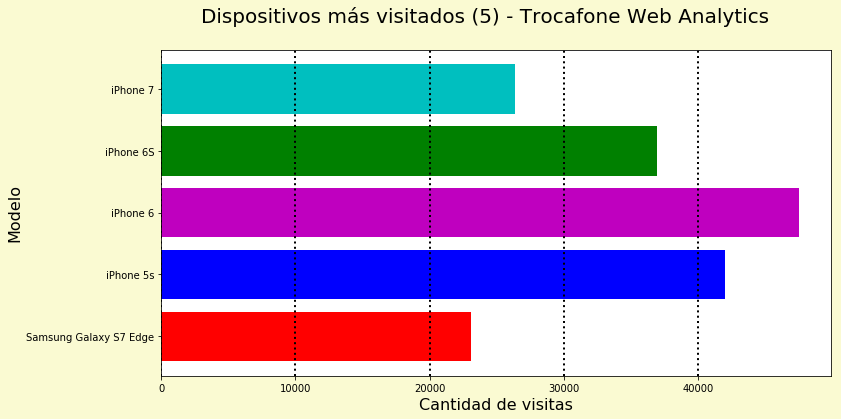

In [8]:
# plot
import matplotlib   #requerido para color map
import matplotlib.pyplot as plt


x_val = [x[0] for x in top5ModelsVec]
y_val = [x[1] for x in top5ModelsVec]

colors = ['m', 'b', 'g', 'c', 'r'] #, 'y', 'g'

fig = plt.figure(figsize=(12, 6),facecolor='lightgoldenrodyellow')
ax = fig.add_subplot(111)
ax.grid(color='k', linestyle=':', linewidth=2, axis='x')

fig.suptitle("Dispositivos más visitados (5) - Trocafone Web Analytics\n", fontsize=20)

ax.barh(x_val, y_val, color=colors)
plt.ylabel('Modelo' , fontsize=16)
plt.xlabel('Cantidad de visitas' , fontsize=16)


# Footer
plt.show()
